In [17]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os
import xarray as xr
import dask
from dask.distributed import Client


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'19', format='%Y%m%d%H')

In [19]:
cells = ee.load_cells(dir_track, day)

In [20]:
cell = cells[83]

In [21]:
cell.keys()

dict_keys(['cell_id', 'parent', 'child', 'merged_to', 'died_of', 'lifespan', 'datelist', 'lon', 'lat', 'mass_center_x', 'mass_center_y', 'max_x', 'max_y', 'delta_x', 'delta_y', 'area_gp', 'max_val', 'score'])

In [22]:
env = ee.load_environments(dir_env, now)

In [23]:
cookie = ee.cutout_cookie(cell, env, now)
cookie

<xarray.Dataset>
Dimensions:       (x: 51, y: 51, pressure: 8)
Coordinates:
    time          datetime64[ns] 2021-06-28T19:00:00
  * x             (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y             (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * pressure      (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
Data variables: (12/61)
    rotated_pole  |S1 ...
    wbtemp_13c    float32 ...
    U_10M         (y, x) float32 ...
    V_10M         (y, x) float32 ...
    VMAX_10M      (y, x) float32 ...
    T_2M          (y, x) float32 ...
    ...            ...
    U             (pressure, y, x) float32 dask.array<chunksize=(8, 51, 51), meta=np.ndarray>
    V             (pressure, y, x) float32 dask.array<chunksize=(8, 51, 51), meta=np.ndarray>
    W             (pressure, y, x) float32 dask.array<chunksize=(8, 51, 51), meta=np.ndarray>
    TOT_PREC      (y, x) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    TOT_SNOW      (y, x) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    DHAIL_MX      (y, x) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:37:13

In [24]:
u_storm = np.nanmean(cell["delta_y"][1::])
v_storm = np.nanmean(cell["delta_x"][1::])

In [25]:
cookie = ee.add_secondary_variables(cookie)
cookie

<xarray.Dataset>
Dimensions:       (pressure: 8, x: 51, y: 51)
Coordinates:
  * pressure      (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x             (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y             (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
    time          datetime64[ns] 2021-06-28T19:00:00
Data variables: (12/69)
    rotated_pole  |S1 b'\x01'
    wbtemp_13c    float32 1.3
    U_10M         (y, x) float32 1.068 1.325 2.461 ... 0.05968 -0.8192 -1.662
    V_10M         (y, x) float32 0.698 0.4855 -0.1347 ... 0.7165 0.5539 0.6513
    VMAX_10M      (y, x) float32 10.28 10.96 13.94 13.15 ... 6.226 6.339 5.71
    T_2M          (y, x) float32 289.2 287.9 286.1 285.0 ... 290.7 290.4 290.2
    ...            ...
    THETA         (pressure, y, x) float32 345.5 345.1 345.0 ... 297.1 296.7
    THETA_2M      (y, x) float32 294.4 294.8 295.4 296.8 ... 295.8 296.1 296.3
    THETA_E       (pressure, y, x) float32 345.6 345.2 345.1 ... 329.0 330.1
    THETA_E_2M    (y, x) float32 325.4 325.3 325.1 325.6 ... 330.5 330.5 330.5
    VORT          (pressure, y, x) float64 0.09486 0.02592 ... 0.2068 0.8389
    DIV           (pressure, y, x) float64 0.544 0.4868 0.4642 ... -0.3649 1.172
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:37:13

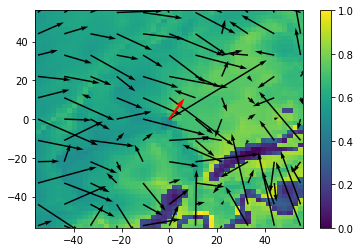

In [26]:
pressure = 925
plt.pcolormesh(cookie.x,cookie.y,cookie.T.sel(pressure= pressure * 100))
stride= 5
plt.quiver(cookie.x[::stride],cookie.y[::stride],cookie.U.sel(pressure=pressure * 100)[::stride,::stride],cookie.V.sel(pressure=pressure * 100)[::stride,::stride], scale=30)
plt.quiver(0,0,u_storm,v_storm, scale=30, color='r')
plt.colorbar()

In [27]:
r_cookie = ee.rotate_cookie(cookie,cell)

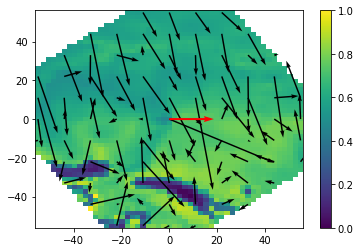

In [28]:
pressure = 925
plt.pcolormesh(r_cookie.x,r_cookie.y,r_cookie.T.sel(pressure= pressure * 100))
stride= 5
plt.quiver(cookie.x[::stride],r_cookie.y[::stride],r_cookie.U.sel(pressure=pressure * 100)[::stride,::stride],r_cookie.V.sel(pressure=pressure * 100)[::stride,::stride], scale=30)
plt.quiver(0,0,5,0, scale=30, color='r')
plt.colorbar()

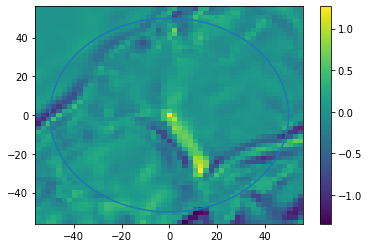

In [29]:
plt.pcolormesh(cookie.x,cookie.y,cookie.W.sel(pressure=92500).squeeze())
# plot circle
circle = plt.plot(np.sin(np.linspace(0,2*np.pi,100))*50,np.cos(np.linspace(0,2*np.pi,100))*50)
plt.colorbar()

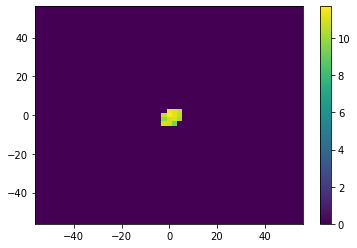

In [30]:
plt.pcolormesh(cookie.x,cookie.y,cookie.DHAIL_MX)
plt.colorbar()

In [55]:
inpath = "/home/kbrennan/phd/data/climate/cookies/present"

# load data
dset = xr.open_mfdataset(inpath + "/*.nc", combine="by_coords", parallel=True)

In [56]:
dset

<xarray.Dataset>
Dimensions:        (cookie_id: 221, x: 51, y: 51, pressure: 8)
Coordinates:
  * cookie_id      (cookie_id) int64 202106010001100 ... 202106180016200
  * pressure       (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/78)
    rotated_pole   (cookie_id, x, y) |S1 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    wbtemp_13c     (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    U_10M          (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    V_10M          (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    VMAX_10M       (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    T_2M           (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    ...             ...
    max_val        (cookie_id) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    real_time      (cookie_id) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_start    (cookie_id) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_end      (cookie_id) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_max      (cookie_id) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    itime          (cookie_id) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:                        COSMO driven by ERA5
    source:                       COSMO_5.08
    Conventions:                  CF-1.4
    conventionsURL:               http://www.cfconventions.org/
    creation_date:                202405032245
    cookie_creator:               extract_environment.py
    cookie_creator_version:       0.1
    cookie_creator_version_date:  20240502
    cookie_creator_author:        Killian P. Brennan

In [57]:
# compute stats in parallel
# mean over cell_id
mean = dset.mean(dim="cookie_id", skipna=True)
# 90th percentile over cell_id
# p90 = dset.quantile(0.9, dim="cookie_id", skipna=True)
# standard deviation over cell_id
std = dset.std(dim="cookie_id", skipna=True)

ValueError: dimension cookie_id on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(cookie_id=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [34]:
mean

<xarray.Dataset>
Dimensions:        (x: 51, y: 51, pressure: 8)
Coordinates:
  * pressure       (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/76)
    wbtemp_13c     (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    U_10M          (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    V_10M          (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    VMAX_10M       (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    T_2M           (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    TD_2M          (x, y) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    ...             ...
    cell_lifespan  float32 dask.array<chunksize=(), meta=np.ndarray>
    max_val        float32 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_start    float32 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_end      float32 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_max      float32 dask.array<chunksize=(), meta=np.ndarray>
    itime          float64 dask.array<chunksize=(), meta=np.ndarray>

In [35]:
# mean = mean.compute()

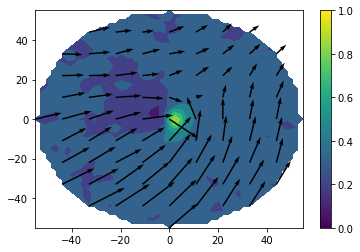

In [46]:
pressure = 850
plt.contourf(mean.x,mean.y,mean.W.sel(pressure= pressure * 100))
stride= 5
plt.quiver(mean.x[::stride],mean.y[::stride],mean.U.sel(pressure=pressure * 100)[::stride,::stride],mean.V.sel(pressure=pressure * 100)[::stride,::stride], scale=30)
plt.colorbar()

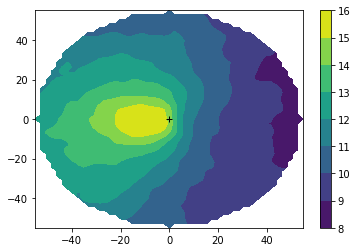

In [58]:
plt.contourf(mean.x,mean.y,mean.VMAX_10M)
plt.plot(0,0,'k+')
plt.colorbar()

In [38]:
mean.pressure

<xarray.DataArray 'pressure' (pressure: 8)>
array([20000., 30000., 40000., 50000., 60000., 70000., 85000., 92500.],
      dtype=float32)
Coordinates:
  * pressure  (pressure) float32 2e+04 3e+04 4e+04 ... 7e+04 8.5e+04 9.25e+04

/tmp/ipykernel_1078/3274434763.py:3: UserWarning: No contour levels were found within the data range.
  plt.contour(mean.x,mean.y,mean.W.sel(pressure=850 * 100),levels=[5],colors='k')


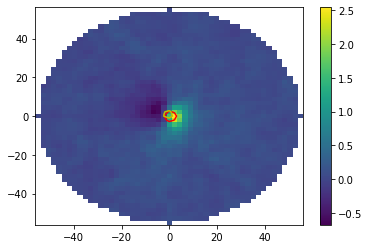

In [39]:
plt.pcolormesh(mean.x,mean.y,mean.W.sel(pressure=850 * 100))
plt.colorbar()
plt.contour(mean.x,mean.y,mean.W.sel(pressure=850 * 100),levels=[5],colors='k')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=600 * 100),levels=[5],colors='r')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=300 * 100),levels=[5],colors='y')